Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [8]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import EarlyStopping


In [9]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [12]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Train_Base")
data_dir_test = pathlib.Path('./Test_Base')

In [13]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [14]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [15]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset='training',
                                                              batch_size=batch_size,seed=123,image_size=(img_height,img_width))

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split =0.2,subset ='validation' ,
                                                             batch_size=batch_size,seed=123,image_size=(img_height,img_width))

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [17]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

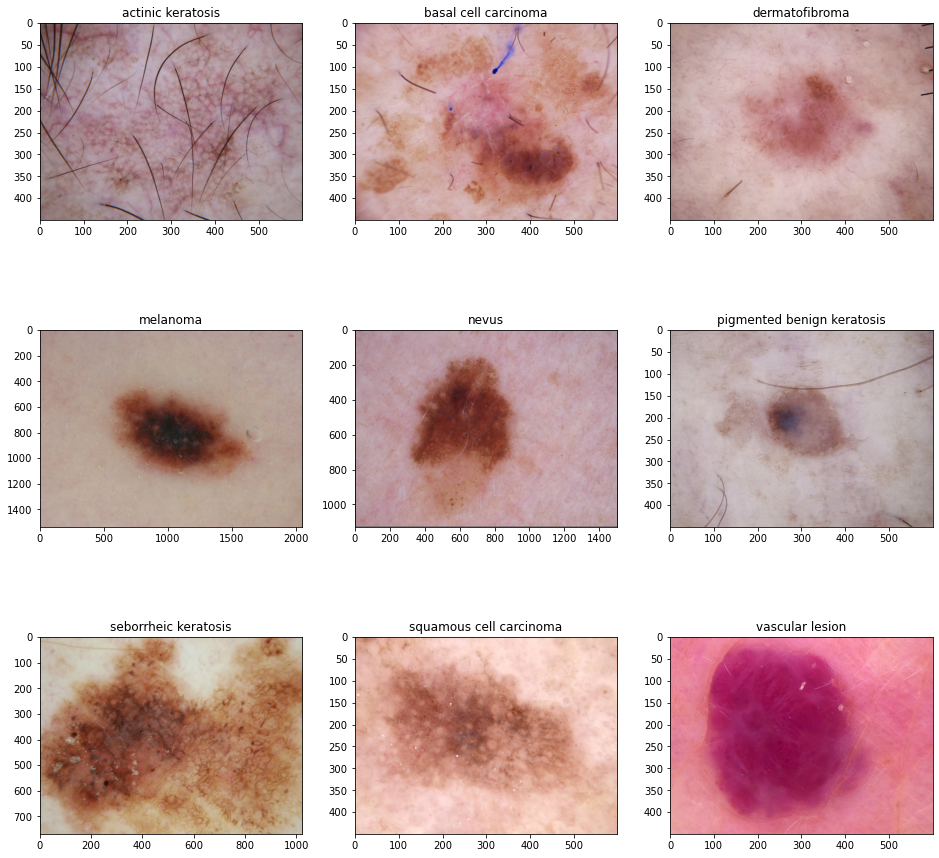

In [18]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 
               'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
plt.figure(figsize=(16,16))

for i in range(len(class_names)):
    plt.subplot(3,3,i+1)
    image = plt.imread(str(list(data_dir_train.glob(class_names[i]+"/*.jpg"))[1]))
    plt.imshow(image)
    plt.title(class_names[i])
    
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [20]:
from keras.layers import Conv2D,Dense,Activation,BatchNormalization,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.regularizers import l2
num_classes=9

In [21]:
model = Sequential([layers.experimental.preprocessing.Rescaling(scale=1./255)])
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [22]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
#model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model.build(input_shape=(None,180,180,3))

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 88, 88, 32)        0         
                                                        

### Train the model

In [24]:
epochs = 20
es = EarlyStopping(monitor='val_loss',mode='min',patience=10)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[es]
)

Epoch 1/20


C:\Users\idhay\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 102s 1s/step - loss: 2.0559 - accuracy: 0.1992 - val_loss: 1.9772 - val_accuracy: 0.2125
Epoch 2/20
56/56 [==============================] - 67s 1s/step - loss: 1.9356 - accuracy: 0.2433 - val_loss: 1.8608 - val_accuracy: 0.3020
Epoch 3/20
56/56 [==============================] - 68s 1s/step - loss: 1.7683 - accuracy: 0.3477 - val_loss: 1.7164 - val_accuracy: 0.3893
Epoch 4/20
56/56 [==============================] - 68s 1s/step - loss: 1.6274 - accuracy: 0.4157 - val_loss: 1.9280 - val_accuracy: 0.2774
Epoch 5/20
56/56 [==============================] - 68s 1s/step - loss: 1.5974 - accuracy: 0.4353 - val_loss: 1.6764 - val_accuracy: 0.3982
Epoch 6/20
56/56 [==============================] - 68s 1s/step - loss: 1.5500 - accuracy: 0.4442 - val_loss: 1.5199 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 67s 1s/step - loss: 1.4781 - accuracy: 0.4855 - val_loss: 1.4488 - val_accuracy: 0.5101
Epoch 8/20
56/56 [============

### Visualizing training results

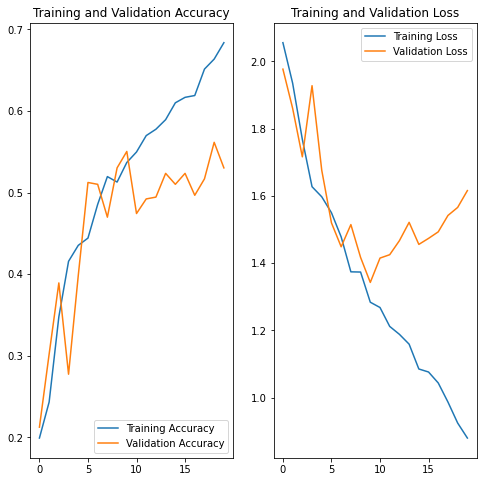

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The model is overfit after about 10 epochs, the validation accuracy has been stable within the range.

### Write your findings here

In [51]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomCrop(200,250),
    layers.RandomWidth(factor=(0.2, 0.3)),
    layers.RandomContrast(factor=(0.2, 0.3))
])

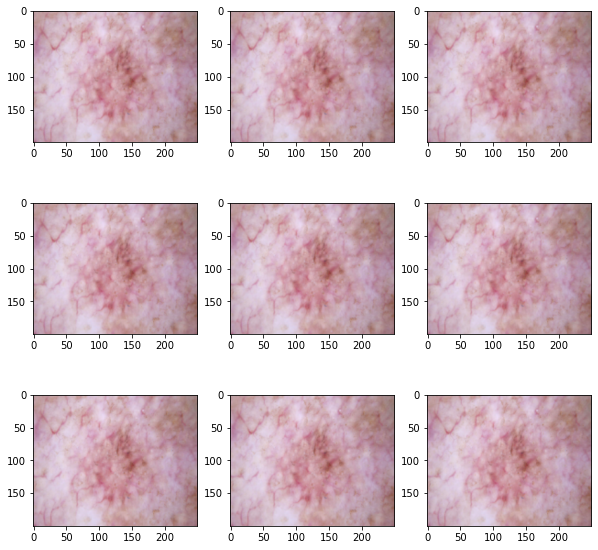

In [53]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10,10))

for images,_ in train_ds.take(4):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [61]:
model = Sequential([data_augmentation,
                    layers.Resizing(img_height,img_width),
                    layers.experimental.preprocessing.Rescaling(scale=1./255)])
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


### Compiling the model

In [62]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(None,180,180,3))

### Training the model

In [63]:
## Your code goes here, note: train your model for 20 epochs
epochs=30
es = EarlyStopping(monitor='val_loss',mode='min',patience=10)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[es]
)

Epoch 1/30
56/56 [==============================] - 33s 571ms/step - loss: 2.1001 - accuracy: 0.1908 - val_loss: 2.0458 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 33s 585ms/step - loss: 1.9796 - accuracy: 0.2238 - val_loss: 1.8861 - val_accuracy: 0.3289
Epoch 3/30
56/56 [==============================] - 37s 658ms/step - loss: 1.8313 - accuracy: 0.3080 - val_loss: 1.7229 - val_accuracy: 0.3490
Epoch 4/30
56/56 [==============================] - 38s 680ms/step - loss: 1.7227 - accuracy: 0.3532 - val_loss: 1.6499 - val_accuracy: 0.4049
Epoch 5/30
56/56 [==============================] - 34s 611ms/step - loss: 1.7510 - accuracy: 0.3571 - val_loss: 1.6495 - val_accuracy: 0.4094
Epoch 6/30
56/56 [==============================] - 36s 640ms/step - loss: 1.6507 - accuracy: 0.4068 - val_loss: 1.5121 - val_accuracy: 0.4519
Epoch 7/30
56/56 [==============================] - 38s 673ms/step - loss: 1.5812 - accuracy: 0.4353 - val_loss: 1.5029 - val_accuracy: 0.4698

### Visualizing the results

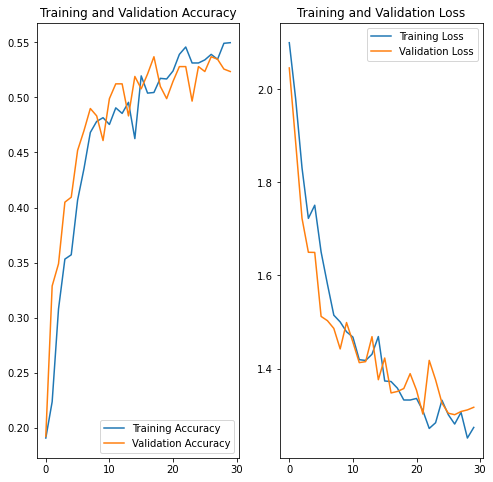

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The model performance is similar to the previous model after data augmentation. However overfitting is addressed in the current model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [65]:
for i in range(9):
    data_dir_train = pathlib.Path("./Train/"+class_names[i])
    image_count = len(list(data_dir_train.glob('*.jpg')))
    print(class_names[i],image_count)

actinic keratosis 114
basal cell carcinoma 376
dermatofibroma 95
melanoma 438
nevus 357
pigmented benign keratosis 462
seborrheic keratosis 77
squamous cell carcinoma 181
vascular lesion 139


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? seborrheic keratosis has least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples? Pigmented benign keratosis dominates the sample population


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [66]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [75]:
import glob
data_dir_train="./Train"
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*/*.jpg'))]
path_list

['./Train\\actinic keratosis\\ISIC_0025780.jpg',
 './Train\\actinic keratosis\\ISIC_0025803.jpg',
 './Train\\actinic keratosis\\ISIC_0025825.jpg',
 './Train\\actinic keratosis\\ISIC_0025953.jpg',
 './Train\\actinic keratosis\\ISIC_0025957.jpg',
 './Train\\actinic keratosis\\ISIC_0025992.jpg',
 './Train\\actinic keratosis\\ISIC_0026040.jpg',
 './Train\\actinic keratosis\\ISIC_0026149.jpg',
 './Train\\actinic keratosis\\ISIC_0026171.jpg',
 './Train\\actinic keratosis\\ISIC_0026194.jpg',
 './Train\\actinic keratosis\\ISIC_0026212.jpg',
 './Train\\actinic keratosis\\ISIC_0026457.jpg',
 './Train\\actinic keratosis\\ISIC_0026468.jpg',
 './Train\\actinic keratosis\\ISIC_0026525.jpg',
 './Train\\actinic keratosis\\ISIC_0026575.jpg',
 './Train\\actinic keratosis\\ISIC_0026625.jpg',
 './Train\\actinic keratosis\\ISIC_0026626.jpg',
 './Train\\actinic keratosis\\ISIC_0026650.jpg',
 './Train\\actinic keratosis\\ISIC_0026702.jpg',
 './Train\\actinic keratosis\\ISIC_0026709.jpg',
 './Train\\actinic k

In [79]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*/*.jpg'))]


In [80]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [81]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,./Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,./Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,./Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,./Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,./Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis
...,...,...
2234,./Train\vascular lesion\ISIC_0033844.jpg,vascular lesion
2235,./Train\vascular lesion\ISIC_0033969.jpg,vascular lesion
2236,./Train\vascular lesion\ISIC_0033991.jpg,vascular lesion
2237,./Train\vascular lesion\ISIC_0034196.jpg,vascular lesion


In [82]:
path_to_training_dataset="./Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FD52F7F790>: 100%|██████████| 500/500 [00:03<00:00, 145.68 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to ./Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FD125B3820>: 100%|██████████| 500/500 [00:03<00:00, 145.35 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ./Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1FD11314B80>: 100%|██████████| 500/500 [00:03<00:00, 144.86 Samples/s]


Initialised with 438 image(s) found.
Output directory set to ./Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=2304x1536 at 0x1FD18EA93D0>: 100%|██████████| 500/500 [00:23<00:00, 21.30 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to ./Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FD19098550>: 100%|██████████| 500/500 [00:25<00:00, 19.97 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to ./Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FD1255CD60>: 100%|██████████| 500/500 [00:05<00:00, 90.52 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to ./Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1FD0C7DF6D0>: 100%|██████████| 500/500 [00:13<00:00, 36.73 Samples/s]


Initialised with 181 image(s) found.
Output directory set to ./Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1FD12510790>: 100%|██████████| 500/500 [00:05<00:00, 88.53 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to ./Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1FD125A6820>: 100%|██████████| 500/500 [00:05<00:00, 88.21 Samples/s]                   


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [84]:
data_dir_train =  pathlib.Path("./Train")

In [85]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [86]:
import glob

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6cff378f-43ae-4e54-a92d-697e5bed2cb7.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7d10c5fc-bf81-4c8a-a772-ef2c244fd0c2.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b9ff42f5-ca78-4235-a87d-12f8375269fc.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_bdb02959-8e28-40b1-aa62-931bd03faf20.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_32a64f88-29cd-4170-92d1-de11bef16816.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_481a01dc-16ed-41a1-b915-be37c6449dcf.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_66e1cfd9-b2eb-42c2-a1eb-2a9c94bdbc7b.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_e9b22f73-1950-494b-ae00-de1c772bc156.jpg',
 'Train\\actinic

In [87]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new


['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [88]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


In [89]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [90]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [91]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [92]:
data_dir_train="./Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height,img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [93]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [103]:
model = Sequential([data_augmentation,
                    layers.Resizing(img_height,img_width),
                    layers.experimental.preprocessing.Rescaling(scale=1./255)])
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128,kernel_regularizer=l2(0.01),activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [104]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(None,180,180,3))

#### **Todo:**  Train your model

In [ ]:
epochs = 50
es = EarlyStopping(monitor='val_loss',mode='min',patience=10)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[es]
)

Epoch 1/50
169/169 [==============================] - 95s 553ms/step - loss: 2.4089 - accuracy: 0.1391 - val_loss: 2.1930 - val_accuracy: 0.1151
Epoch 2/50
169/169 [==============================] - 101s 597ms/step - loss: 2.1821 - accuracy: 0.1448 - val_loss: 2.1852 - val_accuracy: 0.1425
Epoch 3/50
169/169 [==============================] - 109s 645ms/step - loss: 2.1575 - accuracy: 0.1567 - val_loss: 2.1286 - val_accuracy: 0.2249
Epoch 4/50
169/169 [==============================] - 114s 670ms/step - loss: 1.9751 - accuracy: 0.2181 - val_loss: 1.8800 - val_accuracy: 0.2628
Epoch 5/50
169/169 [==============================] - 111s 653ms/step - loss: 1.8631 - accuracy: 0.2763 - val_loss: 1.6877 - val_accuracy: 0.3682
Epoch 6/50
169/169 [==============================] - 118s 695ms/step - loss: 1.6894 - accuracy: 0.3570 - val_loss: 1.6932 - val_accuracy: 0.3682
Epoch 7/50
169/169 [==============================] - 114s 670ms/step - loss: 1.6326 - accuracy: 0.3757 - val_loss: 1.5611 - 

#### **Todo:**  Visualize the model results

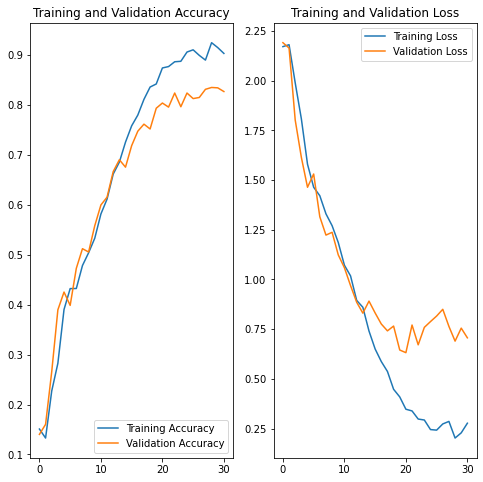

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(31)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Class Rebalance helped in achieving the accuracy of 0.82 

In [ ]:


img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
